<a href="https://colab.research.google.com/github/gauravreddy08/learning-pytorch/blob/main/06_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#06 | **PyTorch** Transfer Learning

https://www.learnpytorch.io/06_pytorch_transfer_learning/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: \"{device}\"")

Device: "cuda"


## Getting **data**

In [3]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [4]:
!git clone https://github.com/gauravreddy08/learning-pytorch
!mv /content/learning-pytorch/going_modular .
!rm -rf learning-pytorch

Cloning into 'learning-pytorch'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 49 (delta 17), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (49/49), 1.59 MiB | 6.77 MiB/s, done.


In [5]:
train_dir = '/content/data/pizza_steak_sushi/train'
test_dir = '/content/data/pizza_steak_sushi/test'

## Preprocessing our **data**

### **Manual** Transforms

In [6]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [7]:
from going_modular import engine, data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataset(train_dir,
                                                                           test_dir,
                                                                           manual_transforms)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fc4a6fc9370>,
 ['pizza', 'steak', 'sushi'])

### **Automatic** Tranforms

In [8]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataset(train_dir=train_dir,
                                                                           test_dir=test_dir,
                                                                           transform=auto_transforms) 

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fc483a18910>,
 ['pizza', 'steak', 'sushi'])

## Getting the **pretrained** model `[EfficientNetB0]`

In [11]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [12]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from torchinfo import summary

summary(model, input_size=[1, 3, 224, 224], 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### Initialsing the model for **Tranfer Learning**
1. **Freezing** the weights
2. Updating the **classifier head**

In [14]:
for param in model.features.parameters():
  param.requires_grad = False

In [15]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [16]:
from torch import nn

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
).to(device)

In [17]:
summary(model, input_size=[32, 3, 224, 224], 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

In [19]:
from going_modular import engine
 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

results = engine.train(model=model,
                       epochs=5, train_data=train_dataloader,
                       loss=loss_fn, optimizer=optimizer,
                       test_data=test_dataloader)

EPOCH [0]
Train Loss: 1.0798, Train Acc: 0.42% | Test Loss: 0.8445, Test Acc: 0.74% 
------------
EPOCH [1]
Train Loss: 0.8384, Train Acc: 0.82% | Test Loss: 0.7727, Test Acc: 0.79% 
------------
EPOCH [2]
Train Loss: 0.7434, Train Acc: 0.83% | Test Loss: 0.7416, Test Acc: 0.79% 
------------
EPOCH [3]
Train Loss: 0.6844, Train Acc: 0.78% | Test Loss: 0.6331, Test Acc: 0.90% 
------------
EPOCH [4]
Train Loss: 0.6093, Train Acc: 0.80% | Test Loss: 0.6184, Test Acc: 0.81% 
------------


In [32]:
loss = torch.tensor(results["train_loss"])
test_loss = torch.tensor(results["test_loss"])

accuracy = torch.tensor(results["train_acc"])
test_accuracy = torch.tensor(results["test_acc"])

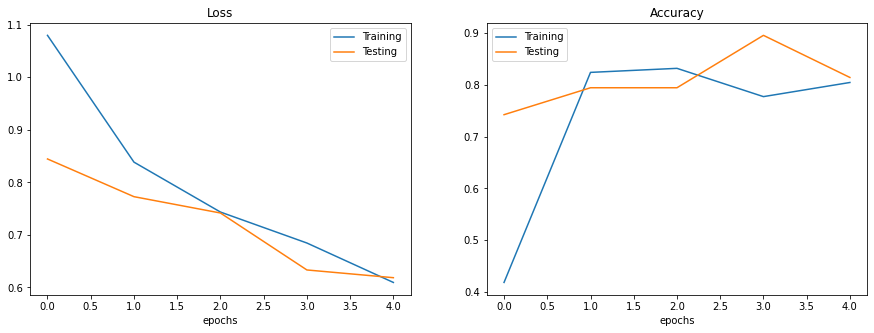

In [36]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(results['epochs'], loss, label='Training')
plt.plot(results['epochs'], test_loss, label='Testing')
plt.title("Loss")
plt.xlabel('epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results['epochs'], accuracy, label='Training')
plt.plot(results['epochs'], test_accuracy, label='Testing')
plt.title("Accuracy")
plt.xlabel('epochs')
plt.legend();

In [61]:
from pathlib import Path

path = Path('/content/data/pizza_steak_sushi/train')

image_path_list = list(path.glob("*/*.jpg"))

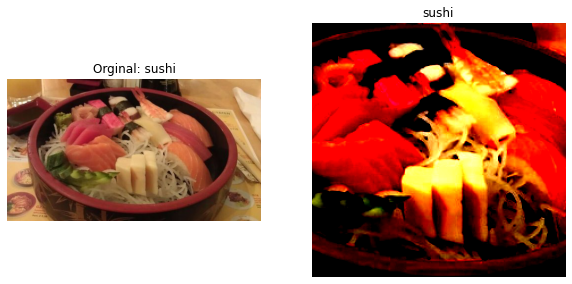

In [65]:
import random
from PIL import Image

model.eval()

plt.figure(figsize=(10, 5))
fpath = random.choice(image_path_list)
img = Image.open(fpath)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Orginal: {fpath.parent.name}")
plt.axis('off');

with torch.inference_mode():
  transformed_image = auto_transforms(img).unsqueeze(dim=0)
  target_image_pred = model(transformed_image.to(device))
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

plt.subplot(1, 2, 2)
plt.imshow(transformed_image.squeeze(dim=0).permute(1, 2, 0))
plt.title(class_names[target_image_pred_label])
plt.axis('off');